In [1]:
import lmfit as lm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lmfit import Parameters, Minimizer
from get_data import get_weather_data, get_dengue_data, plot_data, get_temp
from edo_model_yang import C0, A0, R_m
from edo_model_yang import system_odes, solve_model, solve_fit, plot_fit
from parameters import d, theta_m, mu_a, mu_m, gamma_m, C_yang, sup_cap_sin, sup_cap_yang

In [2]:
# parâmetros que serão fixados: 
# parâmetros fixos 
MU_H = 1/(365*67)    #human mortality rate - day^-1
ALPHA_H = 0.1 #recovering rate - day^-1
THETA_H = 0.027   #intrinsic incubation rate - day^-1
K = 0.5          #fraction of female mosquitoes hatched from all egs
C_A = 0.0      #control effort rate on aquatic phase
C_M = 0.0    #control effort rate on terretrial phase

# população de Foz (censo 2010)
N = 256088

par_fixed = MU_H, THETA_H, ALPHA_H, K, C_A, C_M

In [3]:
df = get_dengue_data()
df.head()

,notified,probable,lab_confirmed,acum_notified
date,,,,
2010-01-07,1.571429,0.857143,0.285714,1.571429
2010-01-08,1.857143,1.000000,0.142857,3.428571
2010-01-09,1.857143,1.000000,0.142857,5.285714
2010-01-10,2.000000,1.142857,0.142857,7.285714
2010-01-11,1.714286,0.857143,0.142857,9.000000


Definindo as condições iniciais

In [4]:
Ms_0 = N

# para T = 28
k = 0.5
delta__ = 8.39
gamma_m__ = 0.12
mu_a__ = 0.06848
mu_m__ = 0.03039
c_m__ = 0.0

A_0 = A0(Ms_0, gamma_m__, mu_m__, c_m__)

C_0 = C0(Ms_0,k,delta__,gamma_m__, mu_m__,mu_a__, c_m = 0, c_a = 0)

Hi0 = 15
Mi0 = 0

print("A0:", A_0)
print("C0:", C_0)

A0: 64854.28600000001
C0: 65600.71992125978


In [5]:
df_2010 = df.loc[(df.index >= '2010-01-08')  &  (df.index <= '2010-07-30')]

data = df_2010.acum_notified

T = get_temp(start_date = '2010-01-08', end_date = '2010-07-30')

df_we = get_weather_data()

df_we = df_we.loc[(df_we.index >= '2010-01-01') & (df_we.index <= '2010-07-30')]

dias = np.arange(0, len(data), 1)

In [6]:
def model_var_onto_cap(t, b_value, beta_value, T, df_we, A0, Mi0, Hi0): 

    MU_H = 1/(365*67)    #human mortality rate - day^-1
    ALPHA_H = 0.1 #recovering rate - day^-1
    THETA_H = 0.027   #intrinsic incubation rate - day^-1
    K = 0.5          #fraction of female mosquitoes hatched from all egs
    C_A = 0.0      #control effort rate on aquatic phase
    C_M = 0.0    #control effort rate on terretrial phase

    # população de Foz (censo 2010)
    N = 256088

    par_fixed = MU_H, THETA_H, ALPHA_H, K, C_A, C_M

    # Aqui serão definidos os parâmetros que serão fitados 
    
    
    b = lambda t:  b_value
    
    beta = lambda t: beta_value
  
    parametros = b, beta
    
    d_ = d(T)
    
    gamma_m_ = gamma_m(T)
    
    mu_a_ = mu_a(T)

    mu_m_ = mu_m(T)
    
    theta_m_ = theta_m(T)
    
    C_ = C_yang(df_we, k=7,w1=0.5, C0 = 5, C1=30,C2 = 0.1)
    
    param_ento = d_, gamma_m_, mu_a_, mu_m_, theta_m_, C_
    
    phi = 1
    
    # definição das condições iniciais
    Ms0 = N
    
    Me0 = 0
    
    Hs0 = phi*N
    
    He0 = 0
    
    Hr0 = (1-phi)*N
    
    y0 = [A0, Ms0, Me0, Mi0, Hs0, He0, Hi0, Hr0]

    # Aqui é solucionado o sistema 
    
    r = solve_model(t, y0, parametros, param_ento, par_fixed)

    Hi = r.y[6]
    Hr = r.y[7] - Hr0

    model = Hi + Hr 

    return model

In [7]:
from lmfit import Model

d_model = Model(model_var_onto_cap, independent_vars = ['t', 'T', 'df_we', 'A0', 'Mi0', 'Hi0'])

In [8]:
d_model.param_names

['b_value', 'beta_value']

In [9]:

# definição dos parâmetros que serão fitados e os seus intervalos 
params = Parameters()

#params.add('phi', value = 0.4, min = 0.1, max = 1, vary = True) # porcentangem de indivíduos susceptíveis
params.add('b_value', value = 0.5, min = 0.3, max = 0.9, vary = True)
params.add('beta_value',value = 0.7,  min = 0.3, max = 0.9, vary = True)
#params.add('C0', value = 5, min = 4, max = 8, vary = True)
#params.add('C2', value = 0.1, min = 0.09, max = 0.5, vary = True)

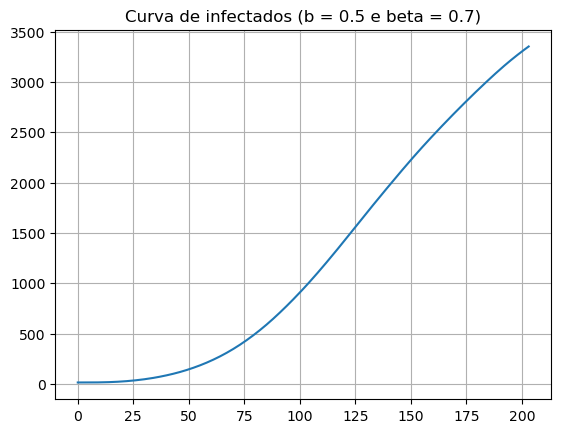

CPU times: user 2.78 s, sys: 11.4 ms, total: 2.79 s
Wall time: 2.79 s


In [10]:
%%time
y_eval = d_model.eval(t = dias, beta_value = 0.7, b_value = 0.5, T = T, df_we = df_we, A0 = A_0, Mi0 = 0, Hi0 = 15)

plt.figure()

plt.plot(y_eval)

plt.title('Curva de infectados (b = 0.5 e beta = 0.7)')

plt.grid()

plt.show()

In [11]:
%%time
result = d_model.fit(data, params, t = dias, T = T, df_we = df_we, A0 = A_0, Mi0 = 0, Hi0 = 15)

result.fit_report()

CPU times: user 1min 8s, sys: 129 ms, total: 1min 8s
Wall time: 1min 8s


'[[Model]]\n    Model(model_var_onto_cap)\n[[Fit Statistics]]\n    # fitting method   = leastsq\n    # function evals   = 20\n    # data points      = 204\n    # variables        = 2\n    chi-square         = 3.5945e+09\n    reduced chi-square = 17794313.9\n    Akaike info crit   = 3407.64559\n    Bayesian info crit = 3414.28183\n    R-squared          = -0.39207149\n[[Variables]]\n    b_value:     0.49999998 +/- 2.9488e-05 (0.01%) (init = 0.5)\n    beta_value:  0.70000000 +/- 1.0767e-05 (0.00%) (init = 0.7)\n[[Correlations]] (unreported correlations are < 0.100)\n    C(b_value, beta_value) = -0.992'

In [12]:
result

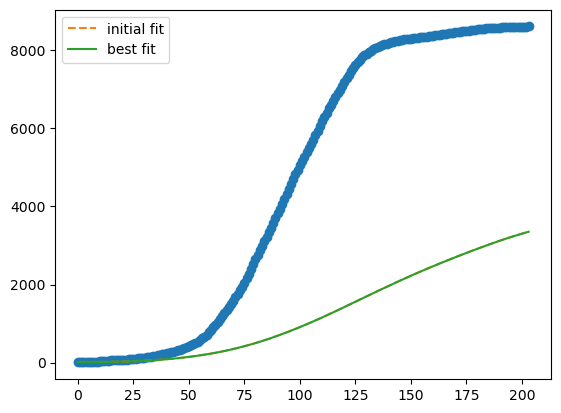

In [13]:
plt.plot(dias, data, 'o')
plt.plot(dias, result.init_fit, '--', label='initial fit')
plt.plot(dias, result.best_fit, '-', label='best fit')
plt.legend()
plt.show()


Using the ModelResult class

In [19]:
from lmfit import Minimizer

In [21]:
Minimizer.ModelFit

AttributeError: type object 'Minimizer' has no attribute 'ModelFit'